## Homework 7

By: 
Keito Watanabe (s6kewata),
Haveesh Singirikonda (s6gusing)

In this assignment, we want to determine the t-matrix. We need to solve the matrix equation $A_{ik} t_{ik} = V_{ij}$.

To do this, we need to:

1. Define a momentum grid for $p, p'$. Make sure to include the N+1th point $p_N = q$.


2. Evaluate the potential (OBEpot) at these points


3. Evaluate the matrix $A_{ik}$ by evaluating the G-L quadrature for $k \in {0, ..., N}$


4. Use `np.linalg.solve` to determine the t-matrix.


In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre

class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat


In [2]:
def transf_leggauss(np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0):
  """Auxilliary method that provides transformed Gauss-Legendre grid points and integration weights.

     This is using a hyperbolic trafo shown in the lecture. 
     Parameter: 
     np1 --  grid points in ]0,pb[
     np2 --  grid points are distributed in ]pb,pc[ using a linear trafo

     pa  -- half of np1 points are in interval [0,pa]
     pb  -- interval boundary as defined above 
     pc  -- upper integration boundary """ 

  x1grid,x1weight=leggauss(np1)
  x2grid,x2weight=leggauss(np2)

  # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
  p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
  p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

  # linear trafo 
  p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
  p2weight=(pc-pb)/2.0*x2weight

  pgrid=np.empty((np1+np2),dtype=np.double)
  pweight=np.empty((np1+np2),dtype=np.double)

  pgrid = np.concatenate((p1grid, p2grid), axis=None)
  pweight = np.concatenate((p1weight, p2weight), axis=None)

  return pgrid,pweight 


In [3]:
def A_mat(q, pgrid, pweights, l, mred, pmax, pval=True):
    '''Coefficient matrix for linear equation'''
    N = len(pgrid)
    
    Aik = np.zeros((N+1, N+1), dtype=complex)
    obepot = OBEpot(cutoff=800, C0=2.470795e-2)
    
    for i in range(N + 1):
        # set pgrid value, pN =q from sheet
        pi = pgrid[i] if i != N else q

        # for k != N
        for k in range(N):
            # the non-trivial term
            aik_num = 2 * mred * obepot.v(pi, pgrid[k], l) * pgrid[k]**2. * pweights[k]
            aik_denom = q**2. - pgrid[k]**2.
            
            aik = aik_num / aik_denom
            
            # evaluate delta term
            if i == k:
                Aik[i,k] = 1. - aik
            else:
                Aik[i,k] = - aik
                
        # for k == N
        ViN = obepot.v(pi, q, l) 
        # first term, integration term
        aiN_1 = 2 * mred * ViN * q**2. * np.sum(pweights / (q**2. - pgrid**2.))
        
        # second term, principal value term
        aiN_2 = mred * q * ViN * np.log((pmax + q) / (pmax - q))

        # take principal value term to zero for Q3
        aiN_2 = aiN_2 if pval else 0
        
        # third term, imaginary term
        aiN_3 = np.pi * mred * q * ViN * 1j
        
        # total term, include delta term
        if i == N:
            aiN = 1 + aiN_1 - aiN_2 + aiN_3
        else:
            aiN = aiN_1 - aiN_2 + aiN_3
            
        # append 
        Aik[i,N] = aiN
        
    return Aik


def qval(E, mred):
    '''On-shell momentum'''
    return np.sqrt(2 * mred * E)
    

In [4]:
def t_mat(E, np1=20, np2=8,pmax=50.,l=0,mred=938.92, pval=True):
    '''t-matrix for two-body scattering problem'''
    # set q value based on E
    E = 1 # 1MeV
    q = qval(E, mred)
    # print("q = {0:.3f} MeV".format(q))

    # we now need to define a momentum grid
    N = np1 + np2

    pmax = q if q > pmax else pmax

    pgrid, pweights = transf_leggauss(np1=np1, np2=np2, pa=1.0, pb=5.0, pc=pmax)

    # evaluate coefficient matrix
    Aik = A_mat(q, pgrid, pweights, l, mred, pmax, pval)

    # potential
    Vij = np.zeros((N+1, N+1),dtype=complex)
    obepot = OBEpot(cutoff=800, C0=2.470795e-2)

    for i in range(N+1):
        pi = pgrid[i] if i != N else q
        
        for j in range(N):
            Vij[i,j] = obepot.v(pi,pgrid[j],l)

        # for N+1th case
        Vij[i,N] = obepot.v(pi,q,l)

    # solve linear equation to get t-matrix element
    tkj = np.linalg.solve(Aik, Vij)

    return tkj



In [5]:
# check if it runs
tkj = t_mat(E=1)
print(tkj[-1,-1])

(-3.856595056814104e-06-4.565764790188304e-06j)


To check for numerical accuracy, we use the fact that $S_l(q) = 1 - 2\pi i \mu q t_l(q,q)$ must be unitary, and do this by checking the argument where the difference $S_l(q) - 1$ is the smallest.

1.0
14


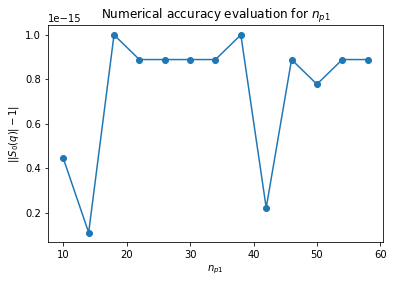

In [6]:
def S_mat(E, np1=20, np2=10,pmax=100.,l=0, mred=938.92, pval=False):
    '''S-matrix'''
    return 1 - 2 * np.pi * mred * qval(E, mred) * t_mat(E, np1, np2, pmax, l, mred, pval=pval)[-1,-1] * 1j

# check naively first
print(np.abs(S_mat(E=1)))

# change np1 first
np1_arr = np.arange(10,60,4)

S_np1_arr = np.zeros(len(np1_arr))

for i, np1 in enumerate(np1_arr):
    S_np1_arr[i] = np.abs(S_mat(E=1, np1=np1, np2=20, pmax=50, l=0, mred=938.92))

# evaluate min of residual
plt.plot(np1_arr, np.abs(S_np1_arr - 1),marker="o")
plt.xlabel("$n_{{p1}}$")
plt.ylabel("$||S_0(q)| - 1|$")
plt.title("Numerical accuracy evaluation for $n_{{p1}}$")
min_idx = np.argmin(np.abs(S_np1_arr - 1))
print(np1_arr[min_idx])

18


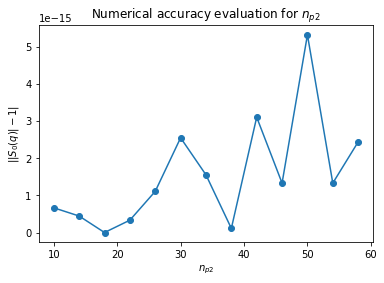

In [7]:
# change np2 first
np2_arr = np.arange(10,60,4)
S_np2_arr = np.zeros(len(np2_arr))

for i, np2 in enumerate(np2_arr):
    S_np2_arr[i] = np.abs(S_mat(E=1, np1=20, np2=np2, pmax=50, l=0, mred=938.92))

# evaluate min of residual
plt.plot(np2_arr, np.abs(S_np2_arr - 1),marker="o")
plt.xlabel("$n_{{p2}}$")
plt.ylabel("$||S_0(q)| - 1|$")
plt.title("Numerical accuracy evaluation for $n_{{p2}}$")
min_idx = np.argmin(np.abs(S_np2_arr - 1))
print(np2_arr[min_idx])

67.88384583800361


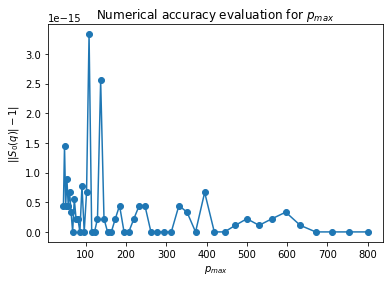

In [8]:
# so it seems like N = 14  + 18 yields the best numerical accuracy.

# now iterate for different pmax values
pmax_arr = np.logspace(np.log10(45),np.log10(800),50)

S_pmax_arr = np.zeros(len(pmax_arr), dtype=complex)

for i, pmax in enumerate(pmax_arr):

    # also evaluate S-matrix
    S_pmax_arr[i] = np.abs(S_mat(E=1, np1=14, np2=18, pmax=pmax, l=0, mred=938.92))


# evaluate min of residual
plt.plot(pmax_arr, np.abs(S_pmax_arr - 1),marker="o")
plt.xlabel("$p_{{max}}$")
plt.ylabel("$||S_0(q)| - 1|$")
plt.title("Numerical accuracy evaluation for $p_{{max}}$")
min_idx = np.argmin(np.abs(S_pmax_arr - 1))
print(pmax_arr[min_idx])

45.00000000000001


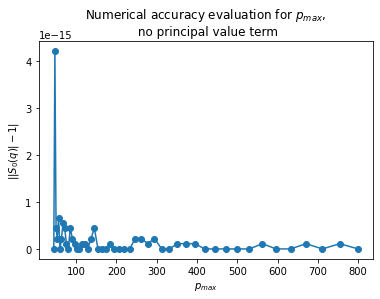

In [9]:
# now excluding the principal value term, perform the same procedure

# now iterate for different pmax values
pmax_arr = np.logspace(np.log10(45),np.log10(800),50)

tkj_pmax_arr = np.zeros(len(pmax_arr), dtype=complex)
S_pmax_arr = np.zeros(len(pmax_arr), dtype=complex)

tkj_nopval_arr = np.zeros(len(pmax_arr),dtype=complex)
S_nopval_arr = np.zeros(len(pmax_arr), dtype=complex)

for i, pmax in enumerate(pmax_arr):
    # evaluate t-matrix
    tkj_pmax_arr[i] = t_mat(E=1, np1=20, np2=8, pmax=pmax, l=0, mred=938.92)[-1,-1]
    tkj_nopval_arr[i] = t_mat(E=1, np1=20, np2=8, pmax=pmax, l=0, mred=938.92, pval=False)[-1,-1]

    # also evaluate S-matrix
    S_pmax_arr[i] = np.abs(S_mat(E=1, np1=20, np2=8, pmax=pmax, l=0, mred=938.92))
    S_nopval_arr[i] = np.abs(S_mat(E=1, np1=20, np2=8, pmax=pmax, l=0, mred=938.92, pval=False))


# evaluate min of residual
plt.plot(pmax_arr, np.abs(S_nopval_arr - 1),marker="o")
plt.xlabel("$p_{{max}}$")
plt.ylabel("$||S_0(q)| - 1|$")
plt.title("Numerical accuracy evaluation for $p_{{max}}$,\n no principal value term")
min_idx = np.argmin(np.abs(S_nopval_arr - 1))
print(pmax_arr[min_idx])

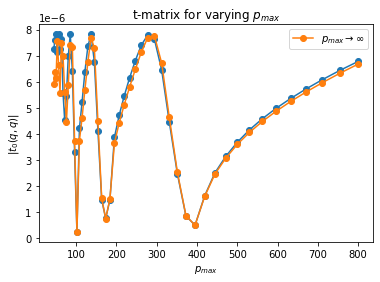

In [17]:
# it would be better if we plot them together
plt.plot(pmax_arr, np.abs(tkj_nopval_arr), marker="o")
plt.plot(pmax_arr, np.abs(tkj_pmax_arr), marker="o", label=r"$p_{{max}} \rightarrow \infty$")
plt.xlabel("$p_{{max}}$")
plt.ylabel("$|t_0(q, q)|$")
plt.title("t-matrix for varying $p_{{max}}$")
plt.legend()

We observe that by varying $p_{max}$, the effects of removing the principal value term is negligible after setting $p_{max}$ to $\approx 500$. We observe that the variation is prevalent at values at $p_{max} <= 100$, which is due to the fact that these $p_{max}$ values are near the pole $q \approx 43$ MeV.

Q4: We already checked for the unitary condition in Q3, which was used to verify the numerical accuracy of the algorithm. Here we will show the results from plotting the phase shift $\delta_l$.

In [11]:
# now we can get the phase shift factor
def del_l(S):
    return 0.5 * np.arctan2(np.imag(S), np.real(S))

en_arr = np.linspace(0, 200)  # MeV
del_0_arr = np.zeros(len(en_arr))

for i, en in enumerate(en_arr):
    s0 = S_mat(en, np1=20, np2=8,pmax=45.,l=0, mred=938.92)
    del_0_arr[i] = del_l(s0)

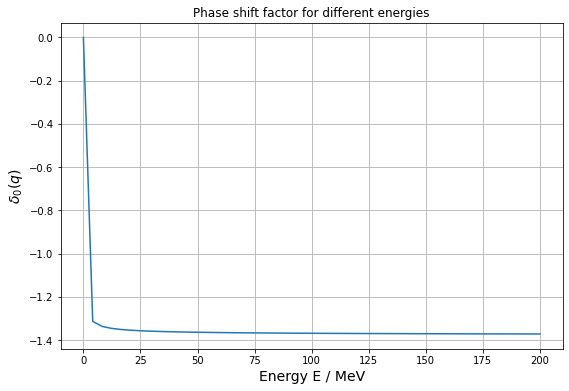

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(en_arr, del_0_arr)
ax.set_xlabel("Energy E / MeV", fontsize=14)
ax.set_ylabel("$\delta_0(q)$", fontsize=14)
ax.set_title("Phase shift factor for different energies")

ax.grid()

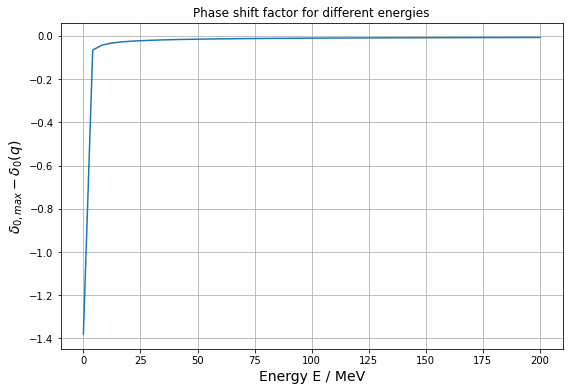

In [13]:
# we observe that the phase factor converges to a value for larger energies.
# perhaps the phase factor converges to zero if we subtract the limiting value of the 
# phase factor.

del_max = del_l(S_mat(E=1e8, np1=20, np2=8,pmax=45.,l=0, mred=938.92))  # some large E

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(en_arr, del_max - del_0_arr)
ax.set_xlabel("Energy E / MeV", fontsize=14)
ax.set_ylabel("$\delta_{{0, max}} - \delta_0(q)$", fontsize=14)
ax.set_title("Phase shift factor for different energies")

ax.grid()

Q5: We analytically derived the differential cross section in terms of the partial waves in the PDF attached below. Below we will show the plots using the valules we obtained from the code.

In [14]:
from scipy.special import eval_legendre

def diff_cs(costheta, l_arr, lp_arr, mred=938.92):
    '''Differential cross section for two-body scattering problem'''

    sum_term = np.zeros(len(costheta))

    for l in l_arr:
        tNN_l = t_mat(E=10, np1=20, np2=8,pmax=50.,l=l,mred=938.92, pval=True)[-1,-1]
        Pl = eval_legendre(l, costheta)
        l_term = (2 * l + 1) * Pl * tNN_l

        for lp in lp_arr:
            tNN_lp = np.conjugate(t_mat(E=10, np1=20, np2=8,pmax=50.,l=lp,mred=938.92, pval=True)[-1,-1])
            Plp = eval_legendre(lp, costheta)
            lp_term = (2 * lp + 1) * Plp * tNN_lp

            sum_term += np.real(l_term * lp_term)  # imaginary component should be zero 
    
    return sum_term * np.pi**2. * mred**2.

In [15]:
# evalaute differential cross section
costheta_arr = np.linspace(-1, 1, 50)
L_arr = [[0], [0,1], [0,1,2], [0,1,2,3], [0,1,2,3,4], [0,1,2,3,4,5], [0,1,2,3,4,5,6]]

diff_cs_arr = np.zeros((len(L_arr), len(costheta_arr)))
for i, l_arr in enumerate(L_arr):
    diff_cs_arr[i,:] = diff_cs(costheta_arr, l_arr, l_arr)

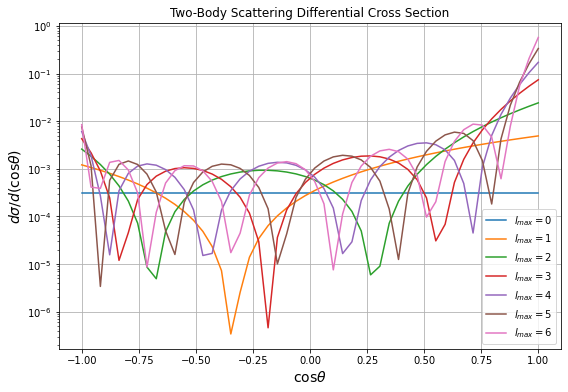

In [16]:

fig, ax = plt.subplots(figsize=(9,6))

for i in range(len(L_arr)):
    ax.semilogy(costheta_arr, diff_cs_arr[i], label="$l_{{max}} = {0:d}$".format(i))

ax.set_xlabel(r"$\cos\theta$", fontsize=14)
ax.set_ylabel(r"$d\sigma / d(\cos\theta)$", fontsize=14)
ax.set_title("Two-Body Scattering Differential Cross Section")
ax.legend()
ax.grid()